In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
words = open('names.txt', 'r').read().splitlines()

In [19]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [20]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [37]:
n_embd = 10
n_hidden = 200
C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3) / (n_embd * block_size)**0.5
# b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [38]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # the bias is subtracted anyways
    
    # NORMALIZE hpreact so that they are unit gaussian
    bnmeani =  hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        # momentum = 0.001
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i < 100_000 else 0.01
    
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10_000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0 /  200000: 3.3004
  10000 /  200000: 2.2536
  20000 /  200000: 2.2813
  30000 /  200000: 1.9794
  40000 /  200000: 2.5385
  50000 /  200000: 2.1757
  60000 /  200000: 2.0682
  70000 /  200000: 2.2655
  80000 /  200000: 2.4917
  90000 /  200000: 2.2988
 100000 /  200000: 1.9415
 110000 /  200000: 2.1215
 120000 /  200000: 2.2519
 130000 /  200000: 2.0057
 140000 /  200000: 1.9909
 150000 /  200000: 2.0043
 160000 /  200000: 2.5736
 170000 /  200000: 2.4364
 180000 /  200000: 2.1866
 190000 /  200000: 2.0179


In [39]:
# calibrate the batch norm at the end of training
# with torch.no_grad():
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     bnmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)

# use the running
bnmean = bnmean_running
bnstd = bnstd_running

In [40]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # NORMALIZE hpreact so that they are unit gaussian
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('test')

train 2.0691168308258057
test 2.1146240234375


In [62]:
# Let's do classes
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar  = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [73]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10_000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break

      0 /  200000: 2.3267


Layer 2 [      Tanh]: mean -0.00, std 0.66, saturated: 10.47%
Layer 5 [      Tanh]: mean -0.00, std 0.70, saturated: 11.16%
Layer 8 [      Tanh]: mean -0.00, std 0.71, saturated: 11.12%
Layer 11 [      Tanh]: mean 0.02, std 0.73, saturated: 9.06%
Layer 14 [      Tanh]: mean -0.01, std 0.75, saturated: 10.38%


Text(0.5, 1.0, 'activation distribution')

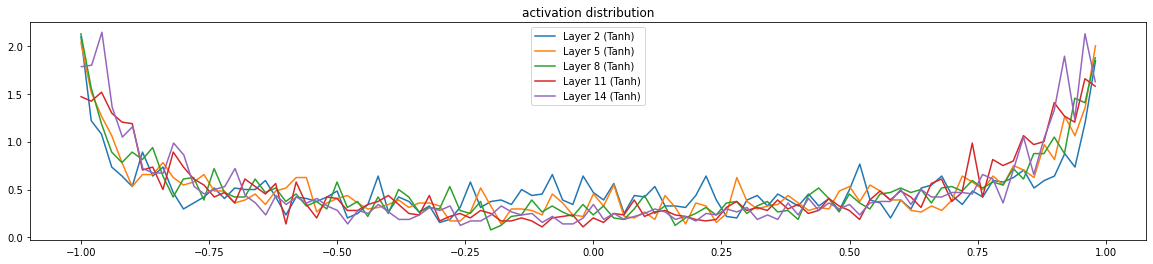

In [74]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('Layer %d [%10s]: mean %.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

Layer 2 [      Tanh]: mean -0.00, std 0.00, saturated: 0.00%
Layer 5 [      Tanh]: mean 0.00, std 0.00, saturated: 0.00%
Layer 8 [      Tanh]: mean -0.00, std 0.00, saturated: 0.00%
Layer 11 [      Tanh]: mean 0.00, std 0.00, saturated: 0.00%
Layer 14 [      Tanh]: mean 0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

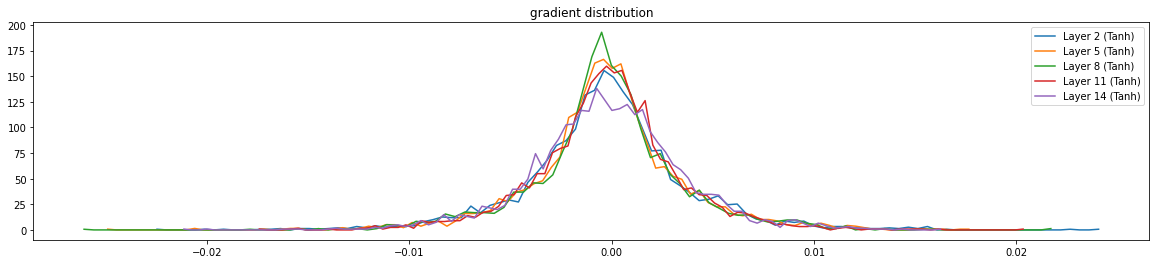

In [75]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('Layer %d [%10s]: mean %.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

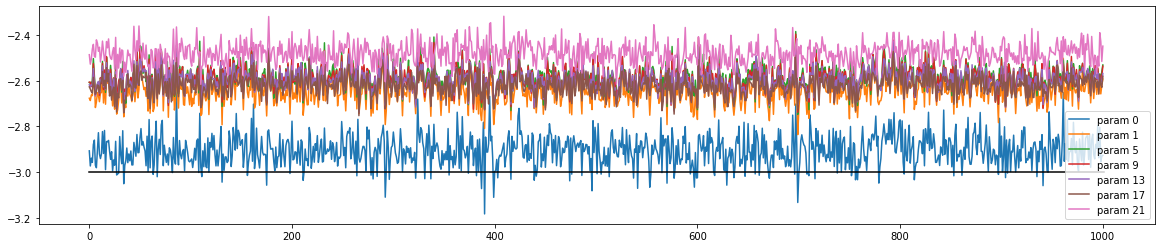

In [76]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

In [77]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # NORMALIZE hpreact so that they are unit gaussian
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('test')

train 3.79225754737854
test 3.780188798904419
